<img align="left" style="max-width: 100px" src="https://github.com/mommermi/IGARSS2024_DataEfficientDeepLearningEO/blob/main/02-mtl/banner_igarss2024.png?raw=1">
<img align="right" style="max-width: 200px" src="https://www.hft-stuttgart.de/fileadmin/Dateien/Marketing/Pressemitteilungen/HFT-logo-klein-Aplustext.jpg">



# IGARSS Tutorial *Data-efficient Deep Learning for Earth Observation* 2024

## Lab - "Data Fusion"

*Michael Mommert, Joelle Hanna, Linus Scheibenreif*


In this tutorial, we will introduce the supervised learning pipeline that we will be using in the different lab sessions today and we will also discuss and implement different Data Fusion concepts to combine different data modalities from our multimodal dataset.

We start by implementing a Neural Network that performs climate zone classification based on Sentinel-2 imagery. As we will build upon this model architecture in the remainder of this tutorial, we choose a U-Net segmentation model as backbone with an appropriate classification head. Once we introduced the model setup and training pipeline, we will extend this architecture to accommodate different data fusion techniques and showcase their use and performance.

Please note that the performance achieved by the models shown here are not really representative, as the dataset that we use here is much too small to achieve robust performances.

## Tutorial Objectives

After this tutorial, you should be able to:

- build your own supervised learning pipeline with `pytorch`;
- implement different early and late date fusion concepts into this pipeline.

## Content

* [Setting up the environment](#setup)
* [Data Handling](#data)
* [Single-Modal Model Setup](#model)
* [Training and Validation Pipeline](#train-val)
* [Evaluation](#evaluation)
* [Intermission: Transfer Learning](#transfer_learning)
* [Data Fusion](#data_fusion)



<a id='setup'></a>
## Setting up the environment

Before we start running this Notebook, please make sure that you have a GPU available for training. If you are using Google Colab, please click `runtime`/`change runtime type` for this purpose and pick `GPU` as hardware accelerator.

We're setting up our Python environment for this lab by installing and importing the necessary modules and packages:

In [ ]:
# we install a number of missing modules
!pip install lightning torchmetrics albumentations rasterio

# system level modules for handling files and file structures
import os
import tarfile
import copy
import gdown

# scipy ecosystem imports for numerics, data handling and plotting
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# pytorch and helper modules
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from torchmetrics import Accuracy

# fast image augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# rasterio for reading in satellite image data
import rasterio as rio
from rasterio.enums import Resampling

We download and extract the **ben-ge-800** dataset, if not yet present:

In [ ]:
if not os.path.exists('ben-ge-800/'):
    gdown.cached_download("https://drive.google.com/file/d/1EDm4naHNhjUWSQRluV2VXHszKiNVc6B4/view?usp=drive_link", "ben-ge-800.tar.gz", fuzzy=True, postprocess=gdown.extractall)

data_base_path = os.path.join(os.path.abspath('.'), 'ben-ge-800')

Cached downloading...
From (original): https://drive.google.com/uc?id=1EDm4naHNhjUWSQRluV2VXHszKiNVc6B4
From (redirected): https://drive.google.com/uc?id=1EDm4naHNhjUWSQRluV2VXHszKiNVc6B4&confirm=t&uuid=95886ea5-6ecd-4380-857d-b26d013341af
To: ben-ge-800.tar.gz
100%|██████████| 183M/183M [00:01<00:00, 158MB/s]


**ben-ge-800** contains samples for 800 locations with co-located Sentinel-1 SAR data, Sentinel-2 multispectral data, elevation data, land-use/land-cover data, as well as environmental data. **ben-ge-800** is a subset of the much larger **ben-ge** dataset (see [https://github.com/HSG-AIML/ben-ge](https://github.com/HSG-AIML/ben-ge) for details.) We deliberately use a very small subset of **ben-ge** to enable reasonable runtimes for the examples shown in this tutorial.

The environment is set up and the data in place. Now we define the dataset classes and dataloaders to access the data efficiently.

<a id='data'></a>
## Data Handling

Large datasets cannot fit entirely in memory and the amount of data available to us tends to increase. This is all the more true for remote sensing data where we have multimodal data available.

Ideally, you would want to load data from your local disk and train your model on GPU, all in parallel. The machinery needed to do this effectively is sophisticated and quite complicated to do yourself. Luckily, Pytorch provides a very useful tool called a `Dataloader`, which handles all of this for you. It provides, sampling, handling different batches, augmentation etc.

First of all, Pytorch’s dataloader must take as input a `Dataset` object.  We need to create this class, which aims to identify the main characteristics of the data you want to generate.
A custom `Dataset` object must implement three functions: `__init__()`, `__len__()`, and `__getitem__()`.

The `__init__()` function  initializes the class. This inherits properties from `torch.utils.data.Dataset`. We store important information there, such as labels or the list of  identifiers.
Each query targets an example whose maximum index is specified in the `__len__()` function.

On each request for an index of a given example, the generator executes the `__getitem__()` method to generate the data associated with it.

In the following, we implement a single dataset class for all modalities in the **ben-ge** dataset, although we will only use a few of those modalities in this tutorial:

In [ ]:
class BENGE(Dataset):
    """A dataset class implementing all ben-ge data modalities."""
    def __init__(self, data_dir=None,
                 s2_bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"],
                 s1_bands=["VH", "VV"]):
        """Dataset class constructor

        keyword arguments:
        data_dir -- string containing the path to the base directory of ben-ge dataset, default: ben-ge-800 directory
        s2_bands -- list of Sentinel-2 bands to be extracted, default: all bands
        s1_bands -- list of Senintel-1 bands to be extracted, default: all bands

        returns:
        BENGE object
        """
        super(BENGE, self).__init__()

        # store some definitions
        if data_dir is None:
            self.data_dir = data_base_path
        else:
            self.data_dir = data_dir
        self.s2_bands = s2_bands
        self.s1_bands = s1_bands
        self.augmentation = A.Compose([ToTensorV2(),])

        # read in relevant data files and definitions
        self.name = self.data_dir.split("/")[-1]
        self.meta = pd.read_csv(f"{self.data_dir}/{self.name}_meta.csv")
        self.ewc_labels = pd.read_csv(f"{self.data_dir}/{self.name}_esaworldcover.csv")
        self.ewc_label_names = ["tree_cover", "shrubland", "grassland", "cropland", "built-up",
                                "bare/sparse_vegetation", "snow_and_ice","permanent_water_bodies",
                                "herbaceous_wetland", "mangroves","moss_and_lichen"]
        self.s2_resampling_factors = {"B01": 6, "B02": 1, "B03": 1, "B04": 1, "B05": 2, "B06": 2, "B07": 2, "B08": 1, "B09": 6, "B11": 2, "B12": 2, "B8A": 2}

    def __getitem__(self, idx):
        """Return sample `idx` as dictionary from the dataset."""
        sample_info = self.meta.iloc[idx]
        patch_id = sample_info.patch_id  # extract Sentinel-2 patch id
        patch_id_s1 = sample_info.patch_id_s1  # extract Sentinel-1 patch id

        s2 = self.load_s2(patch_id).astype(float)  # load Sentinel-2 data
        s2 = np.moveaxis(s2, 0, -1)
        if self.s1_bands:
            s1 = self.load_s1(patch_id_s1).astype(float)  # load Sentinel-1 data
            s1 = (np.clip(s1, a_min=-25, a_max=0) + 25) / 25
        else:
            s1 = None

        # extract top land-use/land-cover label
        label = np.argmax(self.ewc_labels[self.ewc_labels.patch_id == patch_id][self.ewc_label_names])

        # land-use/land-cover map data
        ewc_mask = self.load_ewc(patch_id).astype(float)
        ewc_mask[ewc_mask == 100] = 110
        ewc_mask[ewc_mask == 95] = 100
        ewc_mask = ewc_mask / 10 - 1 # transform to scale [0, 11]
        ewc_mask = np.moveaxis(ewc_mask, 0, -1)

        augmented = self.augmentation(image=s2, mask=ewc_mask)  # generate augmented data

        # reassign and normalize augmented Sentinel-2 data
        s2 = torch.clip(augmented["image"].float() / 10000, 0, 1)

        # reassign augmented land-use/land-cover data
        ewc_mask = augmented["mask"]

        season = sample_info["season_s2"] # seasonal data
        climatezone = {0: 0, 7: 1, 8: 2, 9: 3, 14: 4, 15: 5, 16: 6, 18: 7,
                       25: 8, 26: 9, 27: 10, 29: 11}[sample_info["climatezone"]]  # climatezone data

        # create sample dictionary containing all the data
        sample = {
            "s2": s2,
            "lulc_mask": ewc_mask,
            "patch_id": patch_id,
            "lon": sample_info.lon.item(),
            "lat": sample_info.lat.item(),
            "lulc_top": torch.from_numpy(np.array([label.copy()], dtype=float)),
            "season": season,
            "climatezone": climatezone
            }

        if s1 is not None:  # add Sentinel-1 data, if generated
            sample["s1"] = torch.tensor(s1).float()

        return sample

    def __len__(self):
        """Return length of this dataset."""
        return self.meta.shape[0]

    def load_s2(self, patch_id):
        """Helper function to load Sentinel-2 data for a given `patch_id`."""
        img = []

        for band in self.s2_bands:
            upscale_factor = self.s2_resampling_factors.get(band)
            # read corresponding data file and upsample based on resampling factor
            with rio.open(f"{self.data_dir}/sentinel-2/{patch_id}/{patch_id}_{band}.tif") as d:
                data = d.read(
                out_shape=(
                    d.count,
                    int(d.height * upscale_factor),
                    int(d.width * upscale_factor)
                ),
                resampling=Resampling.bilinear
            )
            img.append(data)

        img = np.concatenate(img)
        return img

    def load_s1(self, s1_patch_id):
        """Helper function to load Sentinel-1 data for a given `patch_id`."""
        img = []

        for band in self.s1_bands:
            # read corresponding data file
            with rio.open(f"{self.data_dir}/sentinel-1/{s1_patch_id}/{s1_patch_id}_{band}.tif") as d:
                data = d.read()
                img.append(data)

        img = np.concatenate(img)
        return img

    def load_ewc(self, patch_id):
        """Helper function to load ESAWorldCover data for a given `patch_id`."""
        with rio.open(f"{self.data_dir}/esaworldcover/{patch_id}_esaworldcover.tif") as d:
            data = d.read()

        return data

    def visualize_observation(self, idx):
        """Visualize data sample `idx`."""

        # define ESA WorldCover colormap
        COLOR_CATEGORIES = [
            (0, 100, 0),
            (255, 187, 34),
            (255, 255, 76),
            (240, 150, 255),
            (250, 0, 0),
            (180, 180, 180),
            (240, 240, 240),
            (0, 100, 200),
            (0, 150, 160),
            (0, 207, 117),
            (250, 230, 160)]
        cmap_all = mpl.colors.ListedColormap(np.array(COLOR_CATEGORIES)/255.)

        # read sample
        sample = self.__getitem__(idx)
        image = sample.get("s2").squeeze()
        mask = sample.get("lulc_mask")

        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        img_rgb = image[[3, 2, 1], :, :]
        img_rgb = np.transpose(img_rgb, (1, 2, 0))
        scaled_img_rgb = (img_rgb - np.min(img_rgb.numpy(), axis=(0,1)))/(np.max(img_rgb.numpy(), axis=(0,1))-np.min(img_rgb.numpy(), axis=(0,1)))

        axs[0].imshow(np.clip(1.5*scaled_img_rgb + 0.1, 0, 1))
        axs[0].set_title("Sentinel-2 RGB")
        axs[0].axis('off')

        mask = mask.squeeze()

        axs[1].imshow(mask, cmap=cmap_all, vmin=0, vmax=11, interpolation=None)
        axs[1].set_title(" Climate Zone: {} \n Season: {} \n Segmentation Mask".format(sample.get("climatezone"), sample.get("season")))
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()
        return



Now that the `BENGE` dataset class is created, we will encapsulate everything in a *Pytorch Lightning* data module, takes care of common data processing and handling steps in *PyTorch*, such as creating `DataLoader`s. A `DataLoader` turns a number of samples (defined by `batch_size`) into a mini-batch for efficient training. By using *Lightning* data modules, we do not have to worry much about `DataLoader`s.

In [ ]:
class BENGEDataModule(pl.LightningDataModule):
    """Pytorch Lightning data module class for ben-ge."""
    def __init__(self):
        """BENGEDataModule constructor."""
        super(BENGEDataModule).__init__()

    def prepare_data(self):
        """Method to prepare data."""
        pass

    def setup(self, data_dir, train_batch_size, eval_batch_size):
        """Method to setup dataset and corresponding splits."""
        dataset = BENGE(data_dir)
        self.trainset, self.valset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.75), int(len(dataset)*0.25)])
        self.valset, self.testset = torch.utils.data.random_split(self.valset, [int(len(dataset)*0.125), int(len(dataset)*0.125)])

        self.train_bs = train_batch_size
        self.eval_bs = eval_batch_size

    def train_dataloader(self):
        """Return training dataset loader."""
        return torch.utils.data.DataLoader(
            self.trainset, batch_size=self.train_bs, num_workers=4, pin_memory=True
        )

    def val_dataloader(self):
        """Return validation dataset loader."""
        return torch.utils.data.DataLoader(
            self.valset, batch_size=self.eval_bs, num_workers=4, pin_memory=True
        )
    def test_dataloader(self):
        """Return test dataset loader."""
        return torch.utils.data.DataLoader(
            self.testset, batch_size=self.eval_bs, num_workers=4, pin_memory=True
        )

Now we can instantiate the data module:

In [ ]:
# we set the random seed value...
seed = 42
pl.seed_everything(seed)

train_batch_size = 32
eval_batch_size = 32

# ... and initialize the data module
data_module = BENGEDataModule()
data_module.setup("./ben-ge-800", train_batch_size, eval_batch_size)

INFO:lightning_fabric.utilities.seed:Seed set to 42


And, finally, we can visualise some observations using the method *visualize_observation()*. Data visualization is the simplest part, but also the most important, to understand the task, and improve the performance of the model. It is important to check a couple of samples, making sure that the groundtruth you're working with is consistent.

From the data module, we can easily access samples in the training dataset:

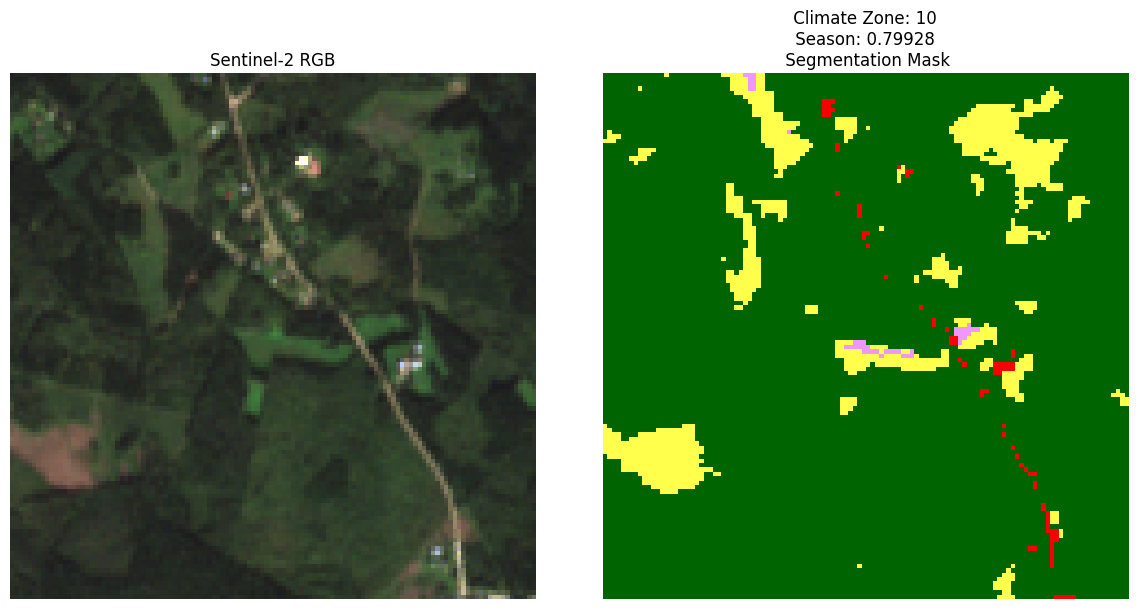

In [ ]:
data_module.trainset.dataset.visualize_observation(100)

<a id='model'></a>
## Single-Modal Model Setup

In this single-modal setup, we follow the default supervised learning setup that we discussed before:

<img align="center" style="max-width: 500px" src="https://github.com/mommermi/IGARSS2024_DataEfficientDeepLearningEO/blob/main/01-data_fusion/supervised_learning_setup.png?raw=1">


In this tutorial, we will use a U-Net ([Ronneberger et al. (2015)](https://arxiv.org/abs/1505.04597) as the shared backbone. As a Fully Convolutional Neural Network, it is predestined to work with image-like data and makes no assumption on the size of the input data (height and width). The architecture of U-Net is composed of two "paths":
- The first one is the contracting path, also called the *encoder*. It is used to capture the context of an image. It is in fact a group of convolution layers and max pooling layers allowing to create a feature map of an image and to reduce its size in order to reduce the number of network parameters.
- The second path is the symmetric expanding, also called *decoder*.

Although conceived as a segmentation model, we will use it across a wide range of downstream tasks, such as segmentation, classification and regression. As a side note: the U-Net could be easily replaced with most other Deep Learning models (depending on the downstream task).
For each downstream task, we will append to the decoder a separate head that is related to the corresponding task.

We build a simple U-Net implementation (following [this implementation](https://github.com/milesial/Pytorch-UNet)):

In [ ]:
# Define the convolution block
class DoubleConv(nn.Module):
    """
    The DoubleConv object is composed of two successive blocks of convolutional layers, batch normalization and ReLU.
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        # Create a sequential module.
        # nn.Sequential is a module inside which you can put other modules that will be applied one after the other.
        self.double_conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),

            # First batchnormalization
            nn.BatchNorm2d(mid_channels),

            # First ReLU activation function
            nn.ReLU(inplace=True),

            # Second convolutional layer
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),

            # Second batchnormalization
            nn.BatchNorm2d(out_channels),

            # Second ReLU activation function
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


# Define the downsampling block
class Down(nn.Module):
    """
    The Down object is composed of a maxpooling layer followed by the DoubleConv block defined above.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Create a sequential module.
        self.maxpool_conv = nn.Sequential(
            # 2D max pooling layer with a kernel size of 2 (meaning spatial dimension will be divided by two)
            nn.MaxPool2d(2),

            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


# Create the upsampling block
class Up(nn.Module):
    """
    The Up object is composed of an upsampling layer (bilinear interpolation) followed by the DoubleConv block defined above.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # upsampling layer with a scale factor of 2 (meaning spatial dimension will be multiplied by two)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNetBackbone(nn.Module):
    """U-Net implementation based on the previously defined building blocks."""
    def __init__(self, n_channels):
        super(UNetBackbone, self).__init__()
        self.n_channels = n_channels

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        return x

Please note that the output of the U-Net will be a feature map of the same size (width x height) as the input image and with 64 output channels (this is a design choice; the number of output channels will be reduced in the head, depending on the downstream task).

In this lab, we will focus on the **classification of climate zones** as our downstream task (other tasks will follow in the multitask learning lab). Therefore, we will also define a classification head that we can use in combination with our U-Net implementation.

In [ ]:
class MulticlassClassificationHead(nn.Module):
    def __init__(self, in_channels, out_channels, num_class):
        super(MulticlassClassificationHead, self).__init__()
        self.out_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(120 * 120, num_class))

    def forward(self, x):
        x1 = self.out_conv(x)
        x2 = x1.view(-1, 120 * 120)
        x_out = self.fc(x2)
        return x_out

This head is applicable to a multi-class classification problem, as we have it in the case of climate zone classification (12 different classes in this dataset). Architecture-wise, the head consists of a single convolutional layer and a single linear layer in combination with dropout.

And now we plug everything together:

In [ ]:
class ClassificationUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(ClassificationUNet, self).__init__()
        self.backbone = UNetBackbone(n_channels)
        self.out = MulticlassClassificationHead(64, 1, n_classes)

    def forward(self, x):
        x = self.backbone(x)
        x_out = self.out(x)

        return x_out

This concludes our model implementation.

<a id='train-val'></a>
### Training and Validation

First of all, let's verify if a GPU is available on our compute machine. If not, the CPU will be used instead.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Device used: {}'.format(device))

Device used: cuda:0


Now we can define the *Pytorch Lightning* trainer class, which takes care of all aspects related to the training of our model:

In [ ]:
class MetricTracker(Callback):
    """This class tracks and enables access to metrics generated during the training process."""
    def __init__(self):
        self.collection = []

    def on_validation_epoch_end(self, trainer, module):
        elogs = copy.deepcopy(trainer.callback_metrics)
        self.collection.append(elogs)


class ClassificationUNetTrainer(pl.LightningModule):
    """This class encapsulates the entire training pipeline for our classification task."""
    def __init__(self, model, criterion, optimizer, scheduler):
        """Constructor for our trainer class.

        positional arguments:
        model -- model instance
        criterion -- loss function instance
        optimizer -- optimizer instance

        keyword arguments:
        scheduler -- learning rate scheduler instance, default: None
        """
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler

        # Train and Validation Metrics:
        self.train_metric = Accuracy(task="multiclass", num_classes=12)
        self.val_metric = Accuracy(task="multiclass", num_classes=12)
        self.test_metric = Accuracy(task="multiclass", num_classes=12)

    def forward(self, img):
        """Forward pass method."""
        return self.model(img)

    def configure_optimizers(self):
        """Optimizer configuration method."""
        if not self.scheduler is None:
            lr_scheduler_config = {
                "scheduler": self.scheduler,
                "interval": "epoch",
                "frequency": 1,
                "monitor": "val_loss",
                "strict": True,
                "name": None,
            }
            return {"optimizer": self.optimizer, "lr_scheduler": lr_scheduler_config}
        else:
            return self.optimizer

    def loss(self, pred, target):
        """Loss computation method."""
        return self.criterion(pred, target)

    def get_target(self, batch):
        """Retrieve target variable for climate zone classification."""
        y = batch["climatezone"].squeeze().long()
        return y

    def training_step(self, train_batch, batch_idx):
        """Training step definition for mini-batch `train_batch` with index `batch_idx`."""
        y = self.get_target(train_batch)  # retrieve target
        data = train_batch["s2"].float()  # retrieve input

        output = self.forward(data)

        train_metric = self.train_metric(output, y)
        train_loss = self.loss(output, y)

        stats = {
            "train_loss": train_loss.item(),
            "train_metric": train_metric.item(),
        }

        self.log_dict(stats, batch_size=data.shape[0], on_step=True, on_epoch=True, prog_bar=True)

        return train_loss

    def validation_step(self, val_batch, batch_idx):
        """Validation step definition for mini-batch `train_batch` with index `batch_idx`."""
        y = self.get_target(val_batch)
        data = val_batch["s2"].float()

        output = self.forward(data)

        val_metric = self.val_metric(output, y)
        val_loss = self.loss(output, y)

        stats = {
            "val_loss": val_loss.item(),
            "val_metric": val_metric.item(),
        }
        self.log_dict(stats, batch_size=data.shape[0], on_step=True, on_epoch=True, prog_bar=True)
        return val_loss

    def test_step(self, test_batch, batch_idx):
        """Test step definition for mini-batch `train_batch` with index `batch_idx`."""
        y = self.get_target(test_batch)
        data = test_batch["s2"].float()

        output = self.forward(data)

        test_metric = self.test_metric(output, y)
        test_loss = self.loss(output, y)

        stats = {
            "test_loss": test_loss.item(),
            "test_metric": test_metric.item(),
        }
        self.log_dict(stats, batch_size=data.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        return test_loss


Our model is now ready to be trained. The following cell defines the missing components like the Loss function, the optimizer and learning rate scheduler and instantiates the trainer.

In [ ]:
model = ClassificationUNet(n_channels=12, n_classes=12)  # we instantiate the model
# n_channels=12 since we have 12 channel Sentinel-2 data
# n_classes=12 since we have 12 different climate zone classes

criterion = torch.nn.CrossEntropyLoss()  # we use cross entropy loss

learning_rate = 0.0001  # we set the learning rate
optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # we use stochastic gradient descent as our optimizer

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)  # we use a Cosine annealing learning rate schedulder

model_trainer = ClassificationUNetTrainer(model, criterion, optimizer, scheduler)  # we instantiate the trainer

metrics_class = MetricTracker()  # we instantiate the metrics tracker

# ... and finally, we instantiate the trainer
trainer = pl.Trainer(
    accelerator='cuda' if 'cuda' in str(device) else 'cpu',
    devices=1,
    max_epochs=5,
    log_every_n_steps=1,
    accumulate_grad_batches=1,
    callbacks=([metrics_class]),
    default_root_dir = "models/ClassificationUNetClimatezone/"
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


And now, we finally start the training process (we will only train the model for a small number of epochs in this tutorial):

In [ ]:
trainer.fit(model_trainer, data_module.train_dataloader(), data_module.val_dataloader())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | ClassificationUNet | 17.4 M | train
1 | criterion    | CrossEntropyLoss   | 0      | train
2 | train_metric | MulticlassAccuracy | 0      | train
3 | val_metric   | MulticlassAccuracy | 0      | train
4 | test_metric  | MulticlassAccuracy | 0      | train
---

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


We can plot and compare the different metrics that were collect during training:

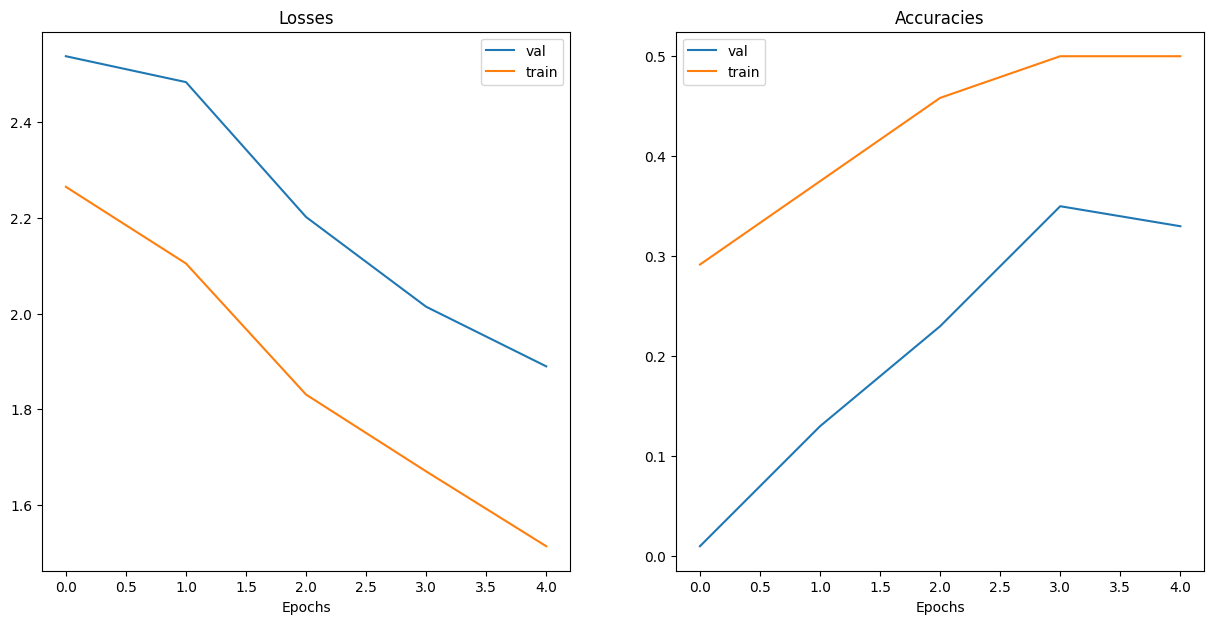

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
val_loss = [el['val_loss_epoch'].cpu() for el in metrics_class.collection[1:]]
train_loss = [el['train_loss'].cpu() for el in metrics_class.collection[1:]]

val_iou = [el['val_metric_epoch'].cpu() for el in metrics_class.collection[1:]]
train_iou = [el['train_metric'].cpu() for el in metrics_class.collection[1:]]

axes[0].plot(val_loss, label='val')
axes[0].plot(train_loss, label='train')
axes[0].set_xlabel('Epochs')
axes[0].set_title('Losses')
axes[0].legend()

axes[1].plot(val_iou, label='val')
axes[1].plot(train_iou, label='train')
axes[1].set_xlabel('Epochs')
axes[1].set_title('Accuracies')
axes[1].legend()

The model is definitely learning something. We could now **tune the model hyperparameters** (e.g., learning rate) and architecture based on the validation loss and metric. We'll skip this process for this tutorial to keep the labs reasonably short.

<a id='evaluation'></a>
### Evaluation

Let's evaluate the trained model on the test dataset:


In [ ]:
trainer.test(model_trainer, dataloaders=data_module.test_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     1.763826608657837     │
│        test_metric        │    0.44999998807907104    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.763826608657837, 'test_metric': 0.44999998807907104}]

The resulting test metrics are not too different from the metrics based on the validation dataset, indicating that the model is not yet overfitting. The observed discrepancy in comparison to the training data is most likely a result of the small dataset size (100 samples in the test split).



## Intermission: Transfer Learning

We briefly talked about Transfer Learning. The idea here is to train a model that is not randomly initialized, but instead to train a model that has been previously trained (pre-trained) on a similar dataset and/or task. We briefly introduce this concept here, since we will take advantage of it in the later lab sessions.

In the end, all you need to do is to load a pre-trained model checkpoint. Here's how to load a pre-trained model checkpoint:

In [ ]:
best_model = ClassificationUNet(n_channels=12, n_classes=12)  # instantiate a new model

# download model checkpoint if not yet present
if not os.path.exists('ClassificationUNet_epoch20.ckpt'):
    !gdown 1c0i-2JeA_UwkFgpsGE4gkVvRckFoFdVv

# load checkpoint
if 'cuda' in str(device):
    state_dict = torch.load("ClassificationUNet_epoch20.ckpt")["state_dict"]
else:
    state_dict = torch.load("ClassificationUNet_epoch20.ckpt", map_location=torch.device('cpu'))["state_dict"]

best_model.load_state_dict({k.replace("model.", "") : v for k,v in state_dict.items()})
best_model.to(device);

Downloading...
From (original): https://drive.google.com/uc?id=1c0i-2JeA_UwkFgpsGE4gkVvRckFoFdVv
From (redirected): https://drive.google.com/uc?id=1c0i-2JeA_UwkFgpsGE4gkVvRckFoFdVv&confirm=t&uuid=be9d3077-786d-459c-9bd0-edf388442248
To: /content/ClassificationUNet_epoch20.ckpt
100% 69.9M/69.9M [00:01<00:00, 40.6MB/s]


Now we can use this loaded model and evaluate it over the test dataset:

In [ ]:
best_model_trainer = ClassificationUNetTrainer(best_model, criterion, optimizer, scheduler)
best_trainer = pl.Trainer(
    accelerator='cuda' if 'cuda' in str(device) else 'cpu',
    devices=1,
    max_epochs=20,
    log_every_n_steps=1,
    accumulate_grad_batches=1,
    callbacks=([metrics_class])
)

best_trainer.test(best_model_trainer, dataloaders=data_module.test_dataloader())

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.1143797636032104     │
│        test_metric        │    0.6600000262260437     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.1143797636032104, 'test_metric': 0.6600000262260437}]

The measured accuracy on the test split is much better than before (46%). This is the result of the additional training: this model was trained for 20 epochs compared to the 5 epochs of the previous model.

In case you are wondering how to save a model checkpoint: you have been doing it all the time. After each training epoch, *PyTorch Lightning* will write the most recent checkpoint to file if you provide a corresonding path string to the `default_root_dir` key in your `Trainer` instance (see above).

## Data Fusion


In the remainder of this lab, we will experiment with some Data Fusion concepts. Namely, we will implement **Early Fusion** and **Late Fusion**. We will also make use of different data modalities to showcase how different data types can be utilized in this process.

### Early Fusion

In Early Fusion, two or more data modalities are combined before they enter the backbone, which in our case is our U-Net model.

<img align="center" style="max-width: 500px" src="https://github.com/mommermi/IGARSS2024_DataEfficientDeepLearningEO/blob/main/01-data_fusion/early_fusion.png?raw=1">

In the simplest case, both modalities have the same dimensionality and shape. The best example for this case is the fusion of Sentinel-1 and Sentinel-2 data.

#### Sentinel-1/2 Data Fusion

In the following example, we will perform Early Fusion of Sentinel-1 and Sentinel-2 data. Both modalities are available from our dataset class, have the same dimensionality and shape. There are two things we have to do:
First, we have to change the number of input channels of our model from 12 to 14 (12 Sentinel-2 + 2 Sentinel-1):

In [ ]:
model_ef = ClassificationUNet(n_channels=14, n_classes=12)

Second, we have to change the different `step` methods in our `ClassificationUNetTrainer` class to perform the concatenation of the data. Note that we will inherit our new class from `ClassficationUNetTrainer` and only change the relevant methods:


In [ ]:
class S12EFClassificationUNetTrainer(ClassificationUNetTrainer):
    """This class encapsulates the entire training pipeline for our
    Sentinel-1/2 early fusion model."""
    def __init__(self, *args):
        super().__init__(*args)

    def training_step(self, train_batch, batch_idx):
        """Training step definition for mini-batch `train_batch` with index `batch_idx`."""
        y = self.get_target(train_batch)
        data_s2 = train_batch["s2"].float()  # retrieve S2 data
        data_s1 = train_batch["s1"].float()  # retrieve S1 data
        data = torch.cat([data_s2, data_s1], dim=1)  # concanenate data along channel dimension

        output = self.forward(data)

        train_metric = self.train_metric(output, y)
        train_loss = self.loss(output, y)

        stats = {
            "train_loss": train_loss.item(),
            "train_metric": train_metric.item(),
        }

        self.log_dict(stats, batch_size=data.shape[0], on_step=True, on_epoch=True, prog_bar=True)

        return train_loss

    def validation_step(self, val_batch, batch_idx):
        """Validation step definition for mini-batch `train_batch` with index `batch_idx`."""
        y = self.get_target(val_batch)
        data_s2 = val_batch["s2"].float()  # retrieve S2 data
        data_s1 = val_batch["s1"].float()  # retrieve S1 data
        data = torch.cat([data_s2, data_s1], dim=1)  # concanenate data along channel dimension

        output = self.forward(data)

        val_metric = self.val_metric(output, y)
        val_loss = self.loss(output, y)

        stats = {
            "val_loss": val_loss.item(),
            "val_metric": val_metric.item(),
        }
        self.log_dict(stats, batch_size=data.shape[0], on_step=True, on_epoch=True, prog_bar=True)
        return val_loss

    def test_step(self, test_batch, batch_idx):
        """Test step definition for mini-batch `train_batch` with index `batch_idx`."""
        y = self.get_target(test_batch)
        data_s2 = test_batch["s2"].float()  # retrieve S2 data
        data_s1 = test_batch["s1"].float()  # retrieve S1 data
        data = torch.cat([data_s2, data_s1], dim=1)  # concanenate data along channel dimension

        output = self.forward(data)

        test_metric = self.test_metric(output, y)
        test_loss = self.loss(output, y)

        stats = {
            "test_loss": test_loss.item(),
            "test_metric": test_metric.item(),
        }
        self.log_dict(stats, batch_size=data.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        return test_loss

In [ ]:
optimizer = optim.SGD(model_ef.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
model_trainer_ef = S12EFClassificationUNetTrainer(model_ef, criterion, optimizer, scheduler)
metrics_class_ef = MetricTracker()

trainer_ef = pl.Trainer(
    accelerator='cuda' if 'cuda' in str(device) else 'cpu',
    devices=1,
    max_epochs=5,
    log_every_n_steps=1,
    accumulate_grad_batches=1,
    callbacks=([metrics_class_ef]),
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer_ef.fit(model_trainer_ef, data_module.train_dataloader(), data_module.val_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | ClassificationUNet | 17.4 M | train
1 | criterion    | CrossEntropyLoss   | 0      | train
2 | train_metric | MulticlassAccuracy | 0      | train
3 | val_metric   | MulticlassAccuracy | 0      | train
4 | test_metric  | MulticlassAccuracy | 0      | train
------------------------------------------------------------
17.4 M    Trainable params
0         Non-trainable params
17.4 M    Total params
69.786    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


That worked, how does the result compare to our Sentinel-2-only baseline model?

In [ ]:
trainer_ef.test(model_trainer_ef, dataloaders=data_module.test_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.9617266654968262     │
│        test_metric        │    0.36000001430511475    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.9617266654968262, 'test_metric': 0.36000001430511475}]

Since this model performs the same task that we used before (predict climate zone), we can compare the performance directly to the metrics that we derived above. For the same training duration (5 epochs), we previously achieved an accuracy of 45% by only training on the 12 Sentinel-2 bands. This model performs worse, which is most likely a result of the model not yet being fully trained and the small size of the dataset.

### Late Fusion

Now we try a different approach to data fusion: Late Fusion. In Late Fusion, we use a separate backbone for each data modality and then combine the representations coming from each backbone before they enter the head.

<img align="center" style="max-width: 500px" src="https://github.com/mommermi/IGARSS2024_DataEfficientDeepLearningEO/blob/main/01-data_fusion/late_fusion.png?raw=1">

The intuition behind this is that each backbone can focus on a single data modality, hopefully learning richer representations than a shared backbone.

We will implement Late Fusion again on the task of climate zone prediction and fuse Sentinel-1 and Sentinel-2 data. For this purpose, we have to build a new model architecture:

In [ ]:
class LFClassificationUNet(nn.Module):
    def __init__(self, n_classes):
        super(LFClassificationUNet, self).__init__()
        self.backbone_s1 = UNetBackbone(2)   # Sentinel-1 backbone (2 input channels)
        self.backbone_s2 = UNetBackbone(12)  # Sentinel-2 backbone (12 input channels)

        self.head = MulticlassClassificationHead(128, 1, n_classes)
        # the classification head now has 128 channels, which is the concatenation of the
        # two outputs from the backbones

    def forward(self, x):
        # we assume that `x` is of shape (batch_size, 14, 120, 120) where
        # axis=1 is split in such a way that [0:13] contains s2 data and
        # [12:] contains the two s1 bands

        z_s1 = self.backbone_s1(x[:,12:,:,:])
        z_s2 = self.backbone_s2(x[:,:12,:,:])

        z = torch.cat((z_s1, z_s2), dim=1)

        return self.head(z)

Since we assume that the input data are a concatenation of Sentinel-2 and Sentinel-1 data, we can simply reuse our first Early Fusion trainer module, `S12EFClassificationUNetTrainer`:

In [ ]:
model_lf = LFClassificationUNet(n_classes=12)

optimizer = optim.SGD(model_lf.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
model_trainer_lf = S12EFClassificationUNetTrainer(model_lf, criterion, optimizer, scheduler)
metrics_class_lf = MetricTracker()

trainer_lf = pl.Trainer(
    accelerator='cuda' if 'cuda' in str(device) else 'cpu',
    devices=1,
    max_epochs=5,
    log_every_n_steps=1,
    accumulate_grad_batches=1,
    callbacks=([metrics_class_lf]),
)

trainer_lf.fit(model_trainer_lf, data_module.train_dataloader(), data_module.val_dataloader())

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                 | Params | Mode 
--------------------------------------------------------------
0 | model        | LFClassificationUNet | 34.7 M | train
1 | criterion    | CrossEntropyLoss     | 0      | train
2 | train_metric | MulticlassAccuracy   | 0      | train
3 | val_metric   | MulticlassAccuracy   | 0      | train
4 | test_metric  | MulticlassAccuracy   | 0      | train
--------------------------------------------------------------
34.7 M    Trainable params
0         Non-trainable params
34.7 M    Total params
138.849   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


The training process has concluded, so let's have a look at the test split results:

In [ ]:
trainer_lf.test(model_trainer_lf, dataloaders=data_module.test_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.6738795042037964     │
│        test_metric        │    0.36000001430511475    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.6738795042037964, 'test_metric': 0.36000001430511475}]

With Late Fusion of Sentinel-1 and Sentinel-2, we obtain a test split accuracy
of 36%, which is identical to the result that we achieve with Early Fusion.


Should Late Fusion perform better than Early Fusion? Not necessarily, oftentimes it does. But be aware that we use two identical backbones in this implementation; this model architecture therefore also has about twice as many parameters as the Early Fusion approach. The larger capacity of this model definitely has a beneficial effect on the model performance.


## Summary

* In this lab we introduced the general supervised learning pipeline, which we will use throughout this tutorial.

* We also introduced two flavors of Data Fusion: Early Fusion and Late Fusion.

* In Early Fusion, different data modalities are fused before they are run through the Deep Learning model.

* In Late Fusion, each data modality is run through a separate backbone model, before the fusion of both outputs is run through the model head.

* In general, it is hard to say which flavor works better. It depends on the downstream task and the available data. However, it is definitely worth to experiment with Data Fusion, as it may provide significant performance benefits.  

## What's next?

We will introduce Multitask Learning next and discuss Self-supervised Learning afterwards.